In [1]:
from sklearn.metrics import confusion_matrix, accuracy_score
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from argparse import Namespace
import seaborn as sns
import numpy as np
import torch

# Import Models

## RetinaVVS Model

In [2]:
from RetinaVVS.RetinaVVS_class import RetinaVVS

In [3]:
hparams = {
    "input_shape": (1, 32, 32),
    "ret_channels": 32,
    "vvs_layers": 4,
    "dropout": 0,
    "lr": 1e-3,
    "model_class": "RetinaVVS"
}
vvs_model = RetinaVVS(hparams)
vvs_model.load_state_dict(torch.load("RetinaVVS/state_dicts/RetChans32_VVSLayers4.tar"))

<All keys matched successfully>

## SIFT Model

In [4]:
from SIFT.SIFT_classes import SIFTRetinaStart

In [5]:
hparams = {
    'model_class': "SIFTRetinaStart",
    "input_shape": (1, 32, 32),
    "ret_channels": 32,
    "vvs_layers": 4,
    "dropout": 0,
    "patch_size": 8,
    "lr": 1e-3
}
sift_model = SIFTRetinaStart(hparams)
sift_model.load_state_dict(torch.load("SIFT/state_dicts/SIFTRetinaStart/RetChans32_VVSLayers4_PatchSize8.tar"))

<All keys matched successfully>

## Conv LBP Model

In [6]:
from LBP.LBP_classes import LBPRetinaStart

In [7]:
hparams = {
    "model_class": "LBPRetinaStart",
    "input_shape": (1, 32, 32),    
    "ret_channels": 32,
    "vvs_layers": 4,
    "dropout": 0,
    "out_channels": 8,
    "kernel_size": 9,
    "sparsity": 0.8,
    "lr": 1e-3
}
lbp_model = LBPRetinaStart(hparams)
lbp_model.load_state_dict(torch.load("LBP/state_dicts/LBPRetinaStart/RetChans32_VVSLayers4_OutChans8_Kernel9_Spars0.8.tar"))

<All keys matched successfully>

# Import data

In [8]:
transform = transforms.Compose([
    transforms.Grayscale(1),
    transforms.ToTensor()
])
test_data = CIFAR10(root="data/CIFAR10", download=False, train=False, transform=transform)
test_loader = DataLoader(test_data, batch_size=32, num_workers=12)

# Predictions

In [9]:
with torch.no_grad():
    # Get Labels
    y_true = torch.cat([labels for _, labels in test_loader], dim=0).reshape(-1).numpy() 
    
    # Get predictions for each model
    vvs_y_pred = torch.cat([vvs_model(images) for images, _ in val_loader], dim=0).reshape(-1, 10).numpy()
    sift_y_pred = torch.cat([sift_model(images) for images, _ in val_loader], dim=0).reshape(-1, 10).numpy()
    lbp_y_pred = torch.cat([lbp_model(images) for images, _ in val_loader], dim=0).reshape(-1, 10).numpy()
    
    # Get ensemble predictions
    ensemble_y_pred = (vvs_y_pred + sift_y_pred + lbp_y_pred) / 3

## RetinaVVS Confusion Matrix

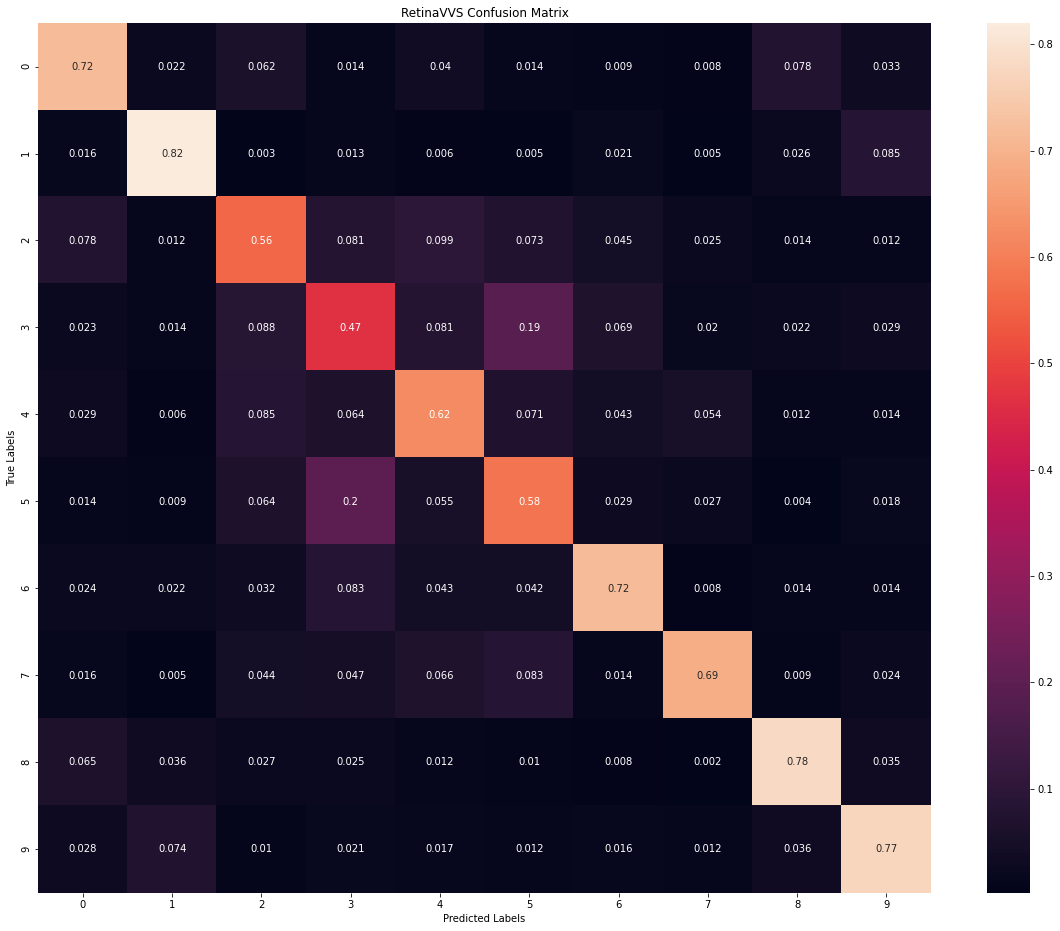

In [10]:
cm = confusion_matrix(y_true, vvs_y_pred.argmax(axis=-1), normalize="true")

fig, ax = plt.subplots(1, figsize=(20,16))
sns.heatmap(cm, annot=True, ax=ax)
ax.set_title("RetinaVVS Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
plt.show()

## SIFT Confusion Matrix

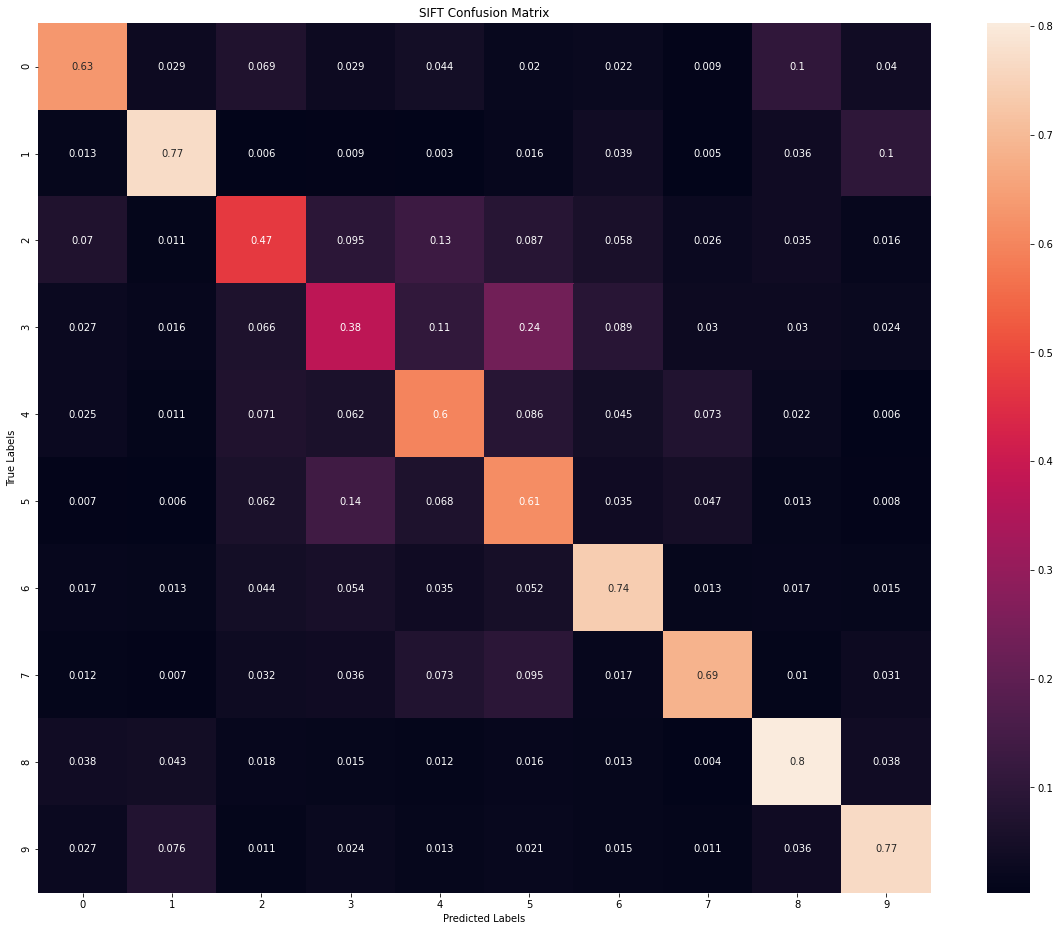

In [11]:
cm = confusion_matrix(y_true, sift_y_pred.argmax(axis=-1), normalize="true")

fig, ax = plt.subplots(1, figsize=(20,16))
sns.heatmap(cm, annot=True, ax=ax)
ax.set_title("SIFT Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
plt.show()

## Conv LBP Confusion Matrix

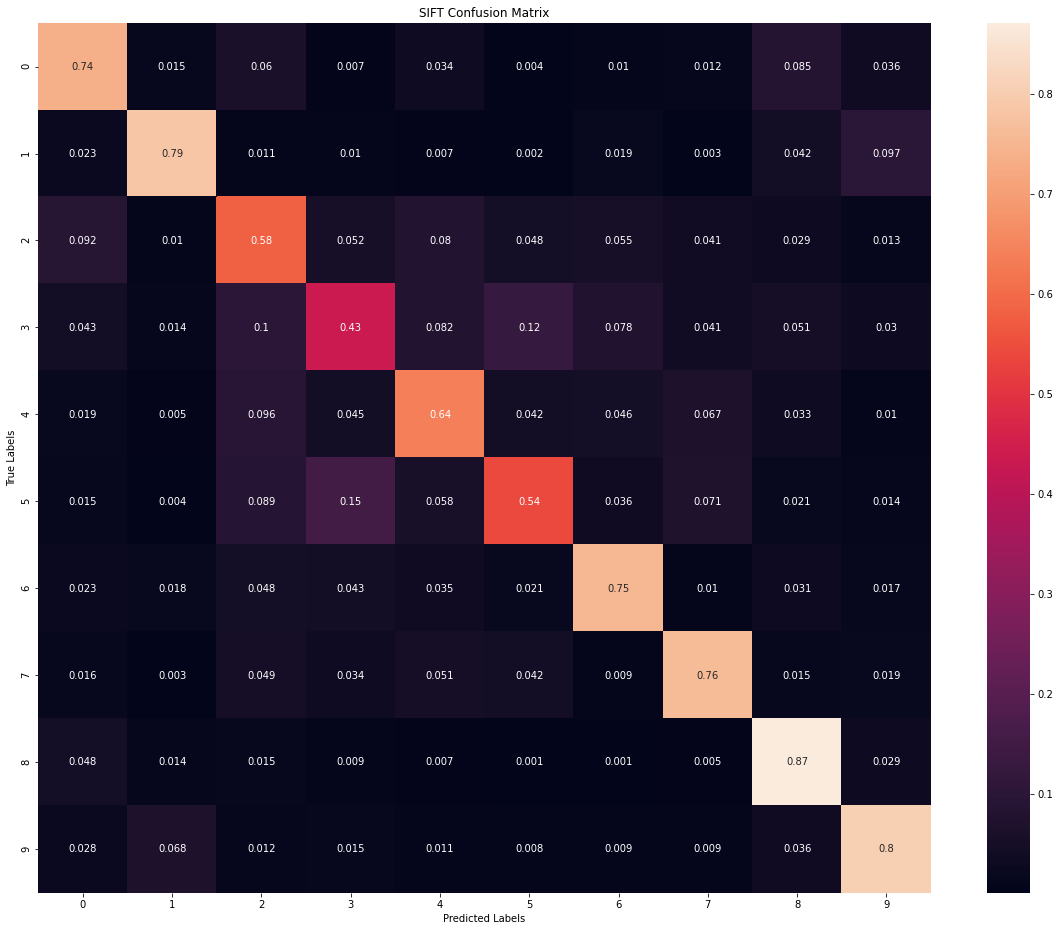

In [12]:
cm = confusion_matrix(y_true, lbp_y_pred.argmax(axis=-1), normalize="true")

fig, ax = plt.subplots(1, figsize=(20,16))
sns.heatmap(cm, annot=True, ax=ax)
ax.set_title("SIFT Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
plt.show()

## Ensemble Confusion Matrix

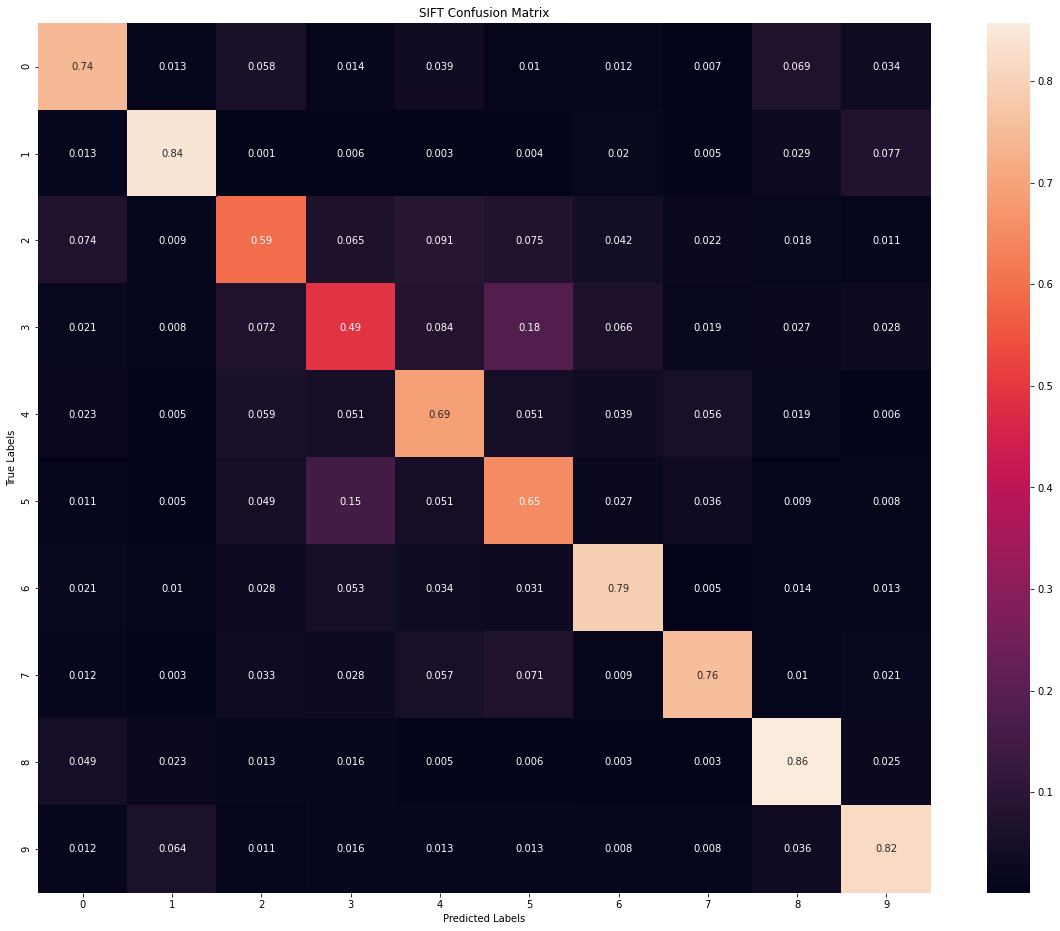

In [13]:
cm = confusion_matrix(y_true, ensemble_y_pred.argmax(axis=-1), normalize="true")

fig, ax = plt.subplots(1, figsize=(20,16))
sns.heatmap(cm, annot=True, ax=ax)
ax.set_title("SIFT Confusion Matrix")
ax.set_xlabel("Predicted Labels")
ax.set_ylabel("True Labels")
plt.show()

# Accuracy comparison

In [15]:
print(f"RetinaVVS Accuracy: {accuracy_score(y_true, vvs_y_pred.argmax(axis=-1))}")
print(f"SIFT Accuracy: {accuracy_score(y_true, sift_y_pred.argmax(axis=-1))}")
print(f"Conv LBP Accuracy: {accuracy_score(y_true, lbp_y_pred.argmax(axis=-1))}")
print(f"Ensemble Accuracy: {accuracy_score(y_true, ensemble_y_pred.argmax(axis=-1))}")

RetinaVVS Accuracy: 0.6734
SIFT Accuracy: 0.6461
Conv LBP Accuracy: 0.6904
Ensemble Accuracy: 0.7234
